## <b>  Recomendation System using Word2Vec
    
    
Word2vec is a technique of creating a Vector Representation (Embeddings) of Words. 
    
Embeddings are word representations that can interpret word meaning and similarity. 
    
> King – man +woman ~= Queen    
    
    

[Reference](https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/)

### <b> Setup 

In [1]:
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec

### <b> Data Loading


In [2]:
df = pd.read_excel('../datasets/recomendations/Online Retail.xlsx')
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
368995,569007,20726,LUNCH BAG WOODLAND,10,2011-09-29 18:51:00,1.65,17552.0,United Kingdom
155132,549967,82582,AREA PATROLLED METAL SIGN,48,2011-04-13 14:21:00,2.10,17873.0,United Kingdom
389831,570488,22766,PHOTO FRAME CORNICE,1,2011-10-10 17:12:00,5.79,14096.0,United Kingdom
63732,541592,84913B,MINT GREEN ROSE TOWEL,1,2011-01-19 15:08:00,3.29,NaN,United Kingdom
127850,547248,22962,JAM JAR WITH PINK LID,2,2011-03-22 09:23:00,1.63,NaN,United Kingdom


### <b>  Data Processing


In [5]:
df.dropna(inplace=True)

In [6]:
'''
    Number of unique custumers
'''
customers = df["CustomerID"].unique().tolist()
len(customers)


2387

In [7]:
'''
    Convert StockCode type
'''
df['StockCode']= df['StockCode'].astype(str)

In [8]:
'''
    Split data in trining and tesing
'''
train_df, valid_df = train_test_split(df, test_size=0.1)
train_df.shape, valid_df.shape

((6748, 8), (750, 8))

In [9]:
'''
    Purchase history of the customers
'''
purchases_train = []
purchases_valid = []

# populate the list with the product codes
for i in train_df['CustomerID']:
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)
    
# populate the list with the product codes
for i in valid_df['CustomerID']:
    temp = valid_df[valid_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_valid.append(temp)    

### <b> Build word2vec Embeddings for Products


In [60]:
'''
    Word2Vec Model
'''
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.02,
                 seed = 14)


model.build_vocab(purchases_train, progress_per=200)
model.train(purchases_train, total_examples = model.corpus_count, epochs=10, report_delay=1)

(764896, 796440)

In [61]:
'''
    Memory efficient
'''
model.init_sims(replace=True)

In [62]:
print(model)

Word2Vec(vocab=1558, size=100, alpha=0.03)


In [63]:
'''
    Extract vectors
'''
X = model[model.wv.vocab]

X.shape

(1558, 100)

### <b> Visualize word2vec Embeddings

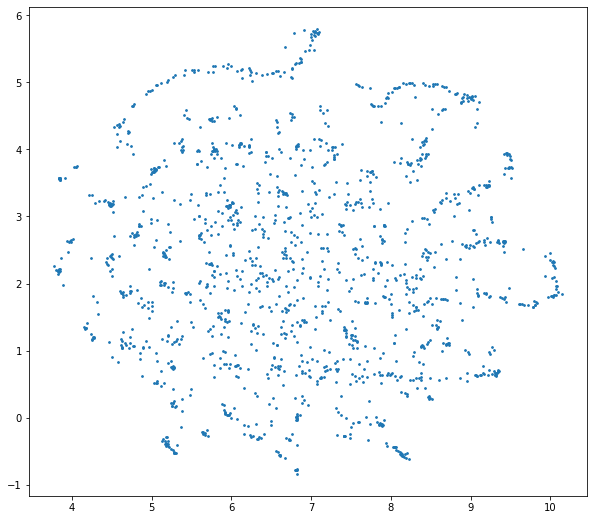

In [64]:
import umap
import matplotlib.pyplot as plt
import seaborn as sea

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

ax = plt.figure(figsize=(10,9))
ax = plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3)

### <b>  Start Recommending Products


In [41]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [69]:
list(products_dict.items())[0:10][8]

('15056BL', ['EDWARDIAN PARASOL BLACK'])

In [77]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

### <b> Define Similar products based on One Product

In [79]:
print('Original Product Description ', list(products_dict.items())[0:10][8])
similar_products(model['15056BL'])

Original Product Description  ('15056BL', ['EDWARDIAN PARASOL BLACK'])


[('DOORMAT RESPECTABLE HOUSE', 0.9457553625106812),
 ('PEARL CRYSTAL PUMPKIN T-LIGHT HLDR', 0.8337986469268799),
 ('EDWARDIAN PARASOL RED', 0.8291891813278198),
 ('DOORMAT UNION FLAG', 0.7719093561172485),
 ('PANTRY CHOPPING BOARD', 0.7049211263656616),
 ('BLACK CHAMPAGNE GLASS', 0.6985478401184082)]

### <b> Define Similar products based on a list of Product

In [81]:
import numpy as np

def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [101]:
# list of purchases of some client
word2vec_embeddings_for_product_list = aggregate_vectors(purchases_valid[4])

len(word2vec_embeddings_for_product_list)

100

In [103]:
similar_products(word2vec_embeddings_for_product_list)

[('JOY WOODEN BLOCK LETTERS', 0.7569479942321777),
 ('BLUE FLY SWAT', 0.7454599142074585),
 ('HANGING FAIRY CAKE DECORATION', 0.7290682792663574),
 ('LUNCH BOX WITH CUTLERY FAIRY CAKES ', 0.7287424802780151),
 ('POLYESTER FILLER PAD 40x40cm', 0.7122691869735718),
 ('BLUE NEW BAROQUE CANDLESTICK CANDLE', 0.7092483639717102)]

### <b> Define Similar products based on a list of Product from Some Client

In [158]:
valid_df[valid_df['CustomerID'] == 14159.0][['StockCode', 'Description']]

,StockCode,Description
326382,22380,TOY TIDY SPACEBOY
135705,22250,DECORATION BUTTERFLY MAGIC GARDEN
213885,82581,TOILET METAL SIGN
326445,23185,FRENCH STYLE STORAGE JAR JAM
483451,22356,CHARLOTTE BAG PINK POLKADOT
25585,22662,LUNCH BAG DOLLY GIRL DESIGN


In [159]:
items = list(valid_df[valid_df['CustomerID'] == 14159.0][['StockCode', 'Description']]['StockCode'].values)
word2vec_embeddings_for_product_list = aggregate_vectors(items)
similar_products(word2vec_embeddings_for_product_list)

[('CHILDS GARDEN SPADE PINK', 0.7712762951850891),
 ('NATURAL SLATE CHALKBOARD LARGE ', 0.753030002117157),
 ('AIRLINE LOUNGE,METAL SIGN', 0.7495642900466919),
 ('BLUE FLY SWAT', 0.7287620306015015),
 ('OVERNIGHT BAG VINTAGE ROSE PAISLEY', 0.7147253155708313),
 ('CHICK GREY HOT WATER BOTTLE', 0.6941677331924438)]

In [161]:
valid_df[valid_df['CustomerID'] == 17841.0][['StockCode', 'Description']]

,StockCode,Description
365668,23212,HEART WREATH DECORATION WITH BELL
356308,20750,RED RETROSPOT MINI CASES
451904,21916,SET 12 RETRO WHITE CHALK STICKS
419953,22428,ENAMEL FIRE BUCKET CREAM
42783,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET
192130,22722,SET OF 6 SPICE TINS PANTRY DESIGN
424212,23403,LETTER HOLDER HOME SWEET HOME
221385,22379,RECYCLING BAG RETROSPOT
328333,21172,PARTY METAL SIGN
537672,23194,GYMKHANA TREASURE BOOK BOX


In [162]:
items = list(valid_df[valid_df['CustomerID'] == 17841.0][['StockCode', 'Description']]['StockCode'].values)
word2vec_embeddings_for_product_list = aggregate_vectors(items)
similar_products(word2vec_embeddings_for_product_list)

[('TOXIC AREA  DOOR HANGER ', 0.7542200684547424),
 ('JOY WOODEN BLOCK LETTERS', 0.7530370354652405),
 ('PETIT TRAY CHIC', 0.749906063079834),
 ('HANGING FAIRY CAKE DECORATION', 0.7493730783462524),
 ('STRAWBERRY SHOPPER BAG', 0.735779881477356),
 ('WHITE HANGING BEADS CANDLE HOLDER', 0.7286043167114258)]